In [1]:
import torch
import scipy
import pickle
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.analysis import pairplot, conditional_pairplot, conditional_corrcoeff
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML, Image
%run load_packages.py
#Loading needed pacakages

/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All bands: ['Gaia_G_MAW', 'Gaia_BP_MAWf', 'Gaia_RP_MAW', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', 'PS_w', 'PS_open', 'DECam_u', 'DECam_g', 'DECam_r', 'DECam_i', 'DECam_z', 'DECam_Y', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_Ks', 'UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 'Tycho_B', 'Tycho_V', 'Hipparcos_Hp', 'Kepler_D51', 'Kepler_Kp', 'TESS'] 

Current subset: ['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']


Filters: ['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
Constructing MIST isochrones...done!
Initializing FastNN predictor...done!


In [2]:
prior=utils.BoxUniform(low=[-0.5,2.02,-2.5],high=[1.5,8.08,0.5])
#Set up the prior, training data for posterior will be drawn from this. Theta=(logM,eep/100,feh) will be generated uniformly from this.
def simulator(theta):
    log_mini,eep_100,feh=theta
    mags,params,params_sec=sedmaker.get_sed(mini=10**log_mini, feh=feh,eep=eep_100*100, smf=0,av=0., rv=3.3,dist=10.)
    return mags+ np.random.randn(len(mags)) * 0.02
#Set up how to simulate the photometry data, adding a .02 error bar.

In [3]:
simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior=prior,density_estimator="maf")
#Prepare for the fit
np.random.seed(123)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=100000)
#Simulate the theta(logM,eep,feh) and the corresponding photometries.

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]/home/jupyter-lukeshen/.local/lib/python3.9/site-packages/brutus/seds.py:360: RuntimeWarning: invalid value encountered in log10
  dlogr = np.log10(1. + (mini - 1.) * drdm)  # radius
Running 100000 simulations.: 100%|██████████| 100000/100000 [00:34<00:00, 2905.35it/s]


In [4]:
k = torch.any(torch.isnan(x), axis = 1)
inference.append_simulations(theta[~k], x[~k])
#Discard nans

In [5]:
fname='/home/jupyter-lukeshen/lukeshen/density_estimator'
try:
    with open(fname, 'rb') as f:
        density_estimator = pickle.load(f)
except:
    density_estimator=inference.train()
    #Training and saving
    with open(fname,'wb') as f:
        pickle.dump(density_estimator,f)
#Load the needed density_estimator file, which is needed for fitting the posterior P(theta|mags)    
   

In [6]:
posterior = inference.build_posterior(density_estimator)
#Fit the posterior

In [7]:
test_prior=utils.BoxUniform(low=[0,3.5,-1],high=[0.5,5.5,-0.5])
#np.random.seed(117)
simulator, test_prior = prepare_for_sbi(simulator, test_prior)
#Now prepare to generate the synthesized data under alpha=(0,0.5,3.5,5.5,-1,-0.5), you can change this.
#alpha are the bounds for logM,eep/100,feh here.

In [8]:
test_theta, test_x = simulate_for_sbi(simulator, test_prior, num_simulations=200)
k_prime = torch.any(torch.isnan(test_x), axis = 1)
test_x=test_x[~k_prime]
#Generate the photometry data and clean out nans

Running 200 simulations.: 100%|██████████| 200/200 [00:00<00:00, 1435.40it/s]


In [9]:
def I(u,l,theta):
    return (u-l)*np.log(u-l)-(u-theta)*np.log(u-theta)-(theta-l)*np.log(theta-l)
#Analytical single variable P(theta) given uniformly distributed logM,eep/100 and feh, assuming independence between variables
class MSSBI:
    def __init__(self,data,batch_size):
        self.data=data
        #photometry data
        self.batch_size=batch_size
        #the batch size for estimating the overlap integral
        self.P_alpha=8/((2*6.06*3)**2)
        #The prior probability for each alpha
    def P_theta_given_alpha(self,theta,alpha):
        tinrange=theta[0]>=alpha[0] and theta[0]<=alpha[1] and theta[1]>=alpha[2] and theta[1]<=alpha[3] and theta[2]>=alpha[4] and theta[2]<=alpha[5]
        #Define whether a theta can be generated by some alpha
        ainrange=alpha[0]>=-0.5 and alpha[1]<=2 and alpha[2]>=2.02 and alpha[3]<=8.08 and alpha[4]>=-3 and alpha[5]<=0.5 and alpha[0]<alpha[1] and alpha[2]<alpha[3] and alpha[4]<alpha[5]   
        #Define whether alpha is within a feasible range
        if tinrange and ainrange:
            V=(alpha[1]-alpha[0])*(alpha[3]-alpha[2])*(alpha[5]-alpha[4])
            return 0.95/V
        #P(theta|alpha) follows multidimensional uniform.
        elif ainrange:
            V=abs((2-alpha[1]+alpha[0])*(6.06-alpha[3]+alpha[2])*(2.5-alpha[5]+alpha[4]))
            return 0.05/V
        #Set the value if theta cannot be generated by some reasonable alpha to be a low value instead of 0 to avioud -inf.
        else:
            return abs(1e-6)
        #Give strong penalty for unreasonable alpha, doing this for mcmc_sampling.
    def P_theta(self,theta):
        return self.P_alpha*I(u=1.5,l=-0.5,theta=theta[0])*I(u=8.08,l=2.02,theta=theta[1])*I(u=0.5,l=-2.5,theta=theta[2])
    #Calculate P(alpha|theta)=P(theta|alpha)P(alpha)/P(theta)
    def P_alpha_given_theta(self,alpha,theta):
        return self.P_theta_given_alpha(theta,alpha)*self.P_alpha/self.P_theta(theta)
    def generate_posterior_samples(self):
        test_posterior_samples=[posterior.sample((self.batch_size,),x=m) for m in self.data]
        self.test_posterior_samples=test_posterior_samples
    """P(alpha|{M_i})=\Pi_{i=1}^n \int P(alpha|theta)P(theta|M_i)d\theta=\Pi_{i=1}^n(E(P(alpha|theta))). The integral is the expected P(alpha|theta)
    under the posterior distribution after observing M_i. We approximate by first sampling thetas from the posteriors 
    and summing the random variables up. For quicker calculation, we pre-generate the posterior samples from the data.
    """
    def store_probability(self):
        P_alpha_over_P_theta=np.zeros((self.batch_size,self.data.shape[0]))
        for i,sample in enumerate(self.test_posterior_samples):
            p_alpha_p_t=[self.P_alpha/self.P_theta(t) for t in sample]
            P_alpha_over_P_theta[:,i]=p_alpha_p_t
        self.P_alpha_over_P_theta=P_alpha_over_P_theta
        """The P(alpha)/P(theta) is also the same for each data points
        """
    def log_P_alpha_given_M(self,alpha):

        test_posterior_samples=self.test_posterior_samples
        #Recall the posterior samples we generated
        integrals=[]
        for i,single_sample in enumerate(test_posterior_samples):
            a=[self.P_theta_given_alpha(theta=t,alpha=alpha) for t in single_sample]
            #For one data point, we calculate P(theta|alpha) for the posterior samples.
            b=self.P_alpha_over_P_theta[:,i]
            #Call the P(alpha)/P(theta) term

             
            integrals.append(np.log(sum(np.array(a)*np.array(b))/self.batch_size))            #Multiplying a and btogether gives us an array of P(alpha|theta) for a single photometry. Averaging gives up expectation
            #Convert to log scale. Integrals variable contains the P(alpha|M) for each datus in test_x
        return integrals
    #To get P(alpha|{M}) for the total set, just use sum(log_P_alpha_given_M)

In [11]:
filename='/home/jupyter-lukeshen/lukeshen/Final_Test_Model'
try:
    
    with open(filename,'rb') as f:
        tmodel=pickle.load(f)
except:
    tmodel=MSSBI(test_x,150)
    tmodel.generate_posterior_samples()
    tmodel.store_probability()
    with open(filename,'wb') as f:
        pickle.dump(tmodel,f)
#Load the model


Drawing 10000 posterior samples:  92%|█████████▏| 9190/10000 [00:04<00:00, 2121.78it/s]
Drawing 10000 posterior samples: 10417it [00:07, 1339.66it/s]                          


tensor([ 0.6163,  2.1763, -1.7876,  6.0811], dtype=torch.float64)


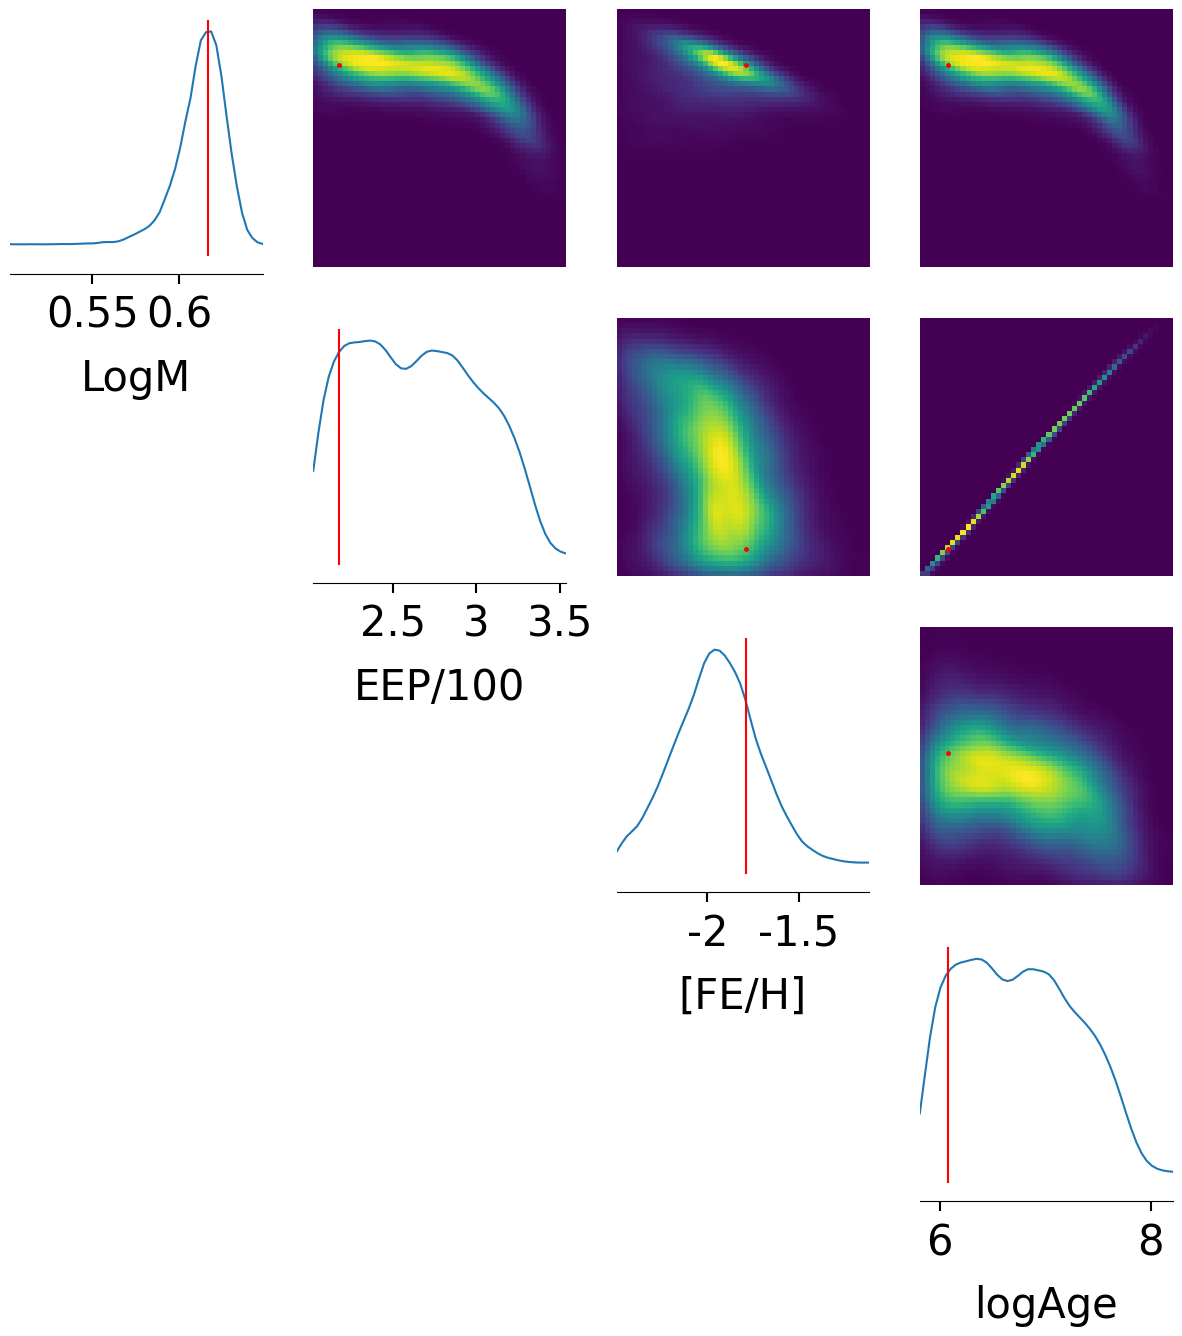

In [35]:
from sbi.analysis import pairplot
import torch

idx=69
x_o = x[idx]


# plot the posterior
np.random.seed(123)
posterior_samples = posterior.sample((10000,), x=x_o)
loga_list=[]
for i,sample in enumerate(posterior_samples):
    mags,params,params_sec=sedmaker.get_sed(mini=10**sample[0], feh=sample[2],eep=sample[1]*100, smf=0,av=0., rv=3.3,dist=10.)
    loga=params['loga']
    
    loga_list.append(loga)
loga_list=np.asarray(loga_list)
#Calculate the loga for all posterior samples
posterior_with_loga=np.column_stack((np.asarray(posterior_samples),loga_list))
posterior_with_loga=torch.as_tensor(posterior_with_loga)
#Append theta with loga
nan_idx=torch.any(torch.isnan(posterior_with_loga),axis=1)
cleaned_posterior_samples=posterior_with_loga[~nan_idx]
cleaned_posterior_samples=torch.as_tensor(cleaned_posterior_samples)
#Clean out nans
log_mini=theta[idx][0]
eep_100=theta[idx][1]
feh=theta[idx][2]
mags,params,params_sec=sedmaker.get_sed(mini=10**log_mini, feh=feh,eep=eep_100*100, smf=0,av=0., rv=3.3,dist=10.)
loga=params['loga']
points=torch.cat((theta[idx],torch.tensor([loga])))
print(points)
fig, ax = pairplot(
    samples= cleaned_posterior_samples,
    points = points,
    points_colors="r",
    points_offdiag={"markersize": 5},
    upper=["kde"],
    diag=["kde"],
    figsize=(15, 15),
    labels = ["LogM", "EEP/100", "[FE/H]",'logAge'],
)
#Plot points. Note that sometimes it may propose a warning to use mcmc. If so, change the idx.

In [36]:
num_sbc_runs = 625  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs=simulator(thetas)
'''xs=[]
for i in range(num_sbc_runs):
    xs.append(simulator(thetas[i]))'''
#Sometimes the code below does not work. If so, use the commented part above.
thetas=torch.as_tensor(thetas)
xs=torch.as_tensor(xs)
k=torch.any(torch.isnan(xs),axis=1)
thetas=thetas[~k]
xs=xs[~k]
#Clean out nans

In [44]:
import tarp
from tarp import get_drp_coverage

In [45]:
partial_samples=[posterior.sample((100,),x=x) for x in xs]
samples=np.stack(partial_samples)
samples = samples.transpose(1, 0, 2)
thetas=np.asarray(thetas)
ecp,alpha=get_drp_coverage(samples,thetas, references='random', metric='euclidean')

#Conduct the Test Against Random Points(TARP). In theory,if our model is good it should return straight line.


Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 11184.21it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]
Drawing 100 posterior samples: 129it [00:00, 152.82it/s]              

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 326.52it/s]

Drawing 100 posterior samples: 179it [00:00, 10354.59it/s]            

Drawing 100 posterior samples: 196it [00:00, 13791.50it/s]            

Drawing 100 posterior samples: 197it [00:00, 13972.03it/s]            

Drawing 100 posterior samples: 190it [00:00, 13427.43it/s]            

Drawing 100 posterior samples: 181it [00:00, 12827.92it/s]            

Drawing 100 posterior samples: 195it [00:00, 13830.88it/s]            

Drawing 100 posterior samples: 190it [00:00, 13306.58it/s]            

Drawing 100 posterior samples: 184it [00:00, 13004.28it/s]            

Drawing 100 posterior samples: 155it [00:00, 11109.13it/s]            

Drawing 100 posterior samples: 184it [00

In [46]:
from scipy.stats import kstest
kstest(ecp,'uniform')

KstestResult(statistic=0.07343873517786564, pvalue=0.9320093145326911, statistic_location=0.28656126482213434, statistic_sign=1)

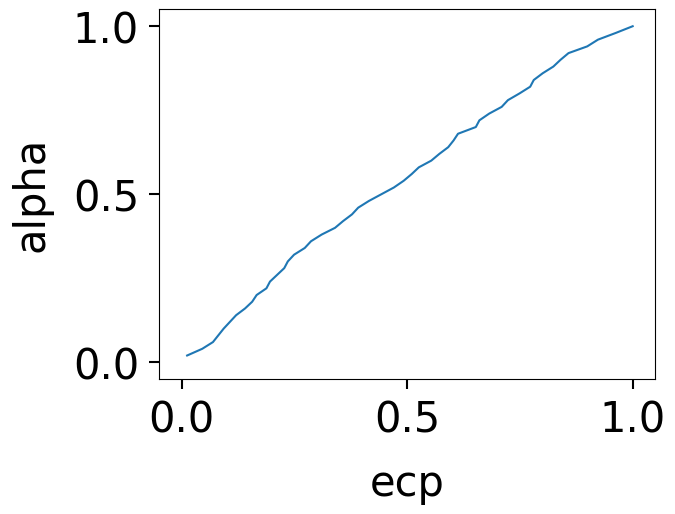

In [57]:
plt.plot(ecp,alpha)
plt.plot(np.arange(0,1,100),np.arange(0,1,100),color='r')
plt.xlabel("ecp")
plt.ylabel("alpha")
plt.show()

In [38]:
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot

In [39]:
num_posterior_samples = 350
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
#Calculate the ranks of posteriors. Error quantiles or ranks ideally follow uniform.  

/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/sbi/analysis/sbc.py:56: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(

Running 506 sbc samples.: 100%|██████████| 506/506 [15:11<00:00,  1.80s/it]
/home/tingli/.conda/envs/myenv/lib/python3.9/site-packages/sbi/analysis/sbc.py:353: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /croot/pytorch-select_1717607455294/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  if (c2st_scores.std(0) > 0.05).any():


kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.10113904 0.08381297 0.04473959]


Text(0.5, 0, '[Fe/H] rank')

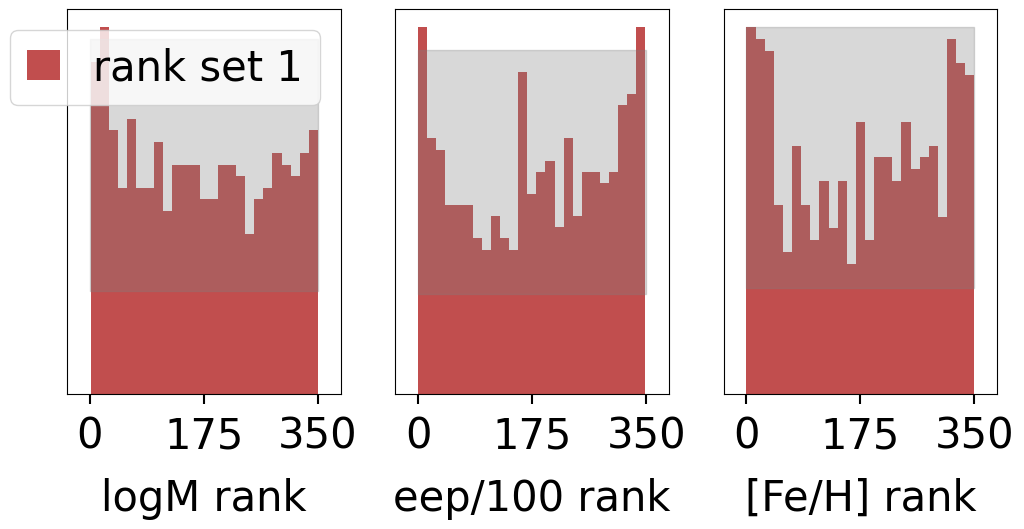

In [42]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,)
ax[0].set_xlabel("logM rank")
ax[1].set_xlabel("eep/100 rank")
ax[2].set_xlabel("[Fe/H] rank")

# by passing None we use a heuristic for the number of bins.
#Plot the sbc ranks. In theory following uniform.

In [12]:
import corner
import emcee

In [13]:
def log_P(alpha):
    print(alpha)
    print(sum(tmodel.log_P_alpha_given_M(alpha)))
    return sum(tmodel.log_P_alpha_given_M(alpha))
#The log probability used for Markov Chain Monte Carlo

In [14]:
def proposal_sampling(n,w1,w2,w3,w4,w5,w6):
    a1=np.random.uniform(low=0-w1,high=0
                         +w1,size=n)
    a2=np.random.uniform(low=0.5-w2,high=0.5+w2,size=n)
    a3=np.random.uniform(low=3.5-w3,high=3.5+w3,size=n)
    a4=np.random.uniform(low=5.5-w4,high=5.5+w4,size=n)
    a5=np.random.uniform(low=-1-w5,high=-1+w5,size=n)
    a6=np.random.uniform(low=-0.5-w6,high=-0.5+w6,size=n)
    sample=np.column_stack([a1,a2,a3,a4,a5,a6])
    return sample
#This is the sampling method for the MCMC. Only used at the start before burn-in.

In [15]:
try:
    mc='/home/jupyter-lukeshen/lukeshen/mcmc_sampler_final'
    with open(mc,'rb') as f:
        sampler=pickle.load(f)
    nwalkers=30
    ndim=6
    #We set 30 walkers.
except:
    nwalkers=30
    ndim=6
    w1=0.05
    w2=0.05
    w3=0.1
    w4=0.1
    w5=0.1
    w6=0.1
    alpha0=proposal_sampling(nwalkers,w1,w2,w3,w4,w5,w6)
    sampler=emcee.EnsembleSampler(nwalkers,ndim,log_P)
    state=sampler.run_mcmc(alpha0,30)
    sampler.reset()
    print('burn in')
    state=sampler.run_mcmc(state,500)
    with open(mc,'wb') as f:
        pickle.dump(sampler,f)
    #Run the MCMC sampling. The first 30 steps are eliminated for burn-in.

Drawing 10000 posterior samples:   0%|          | 0/10000 [1:24:57<?, ?it/s]


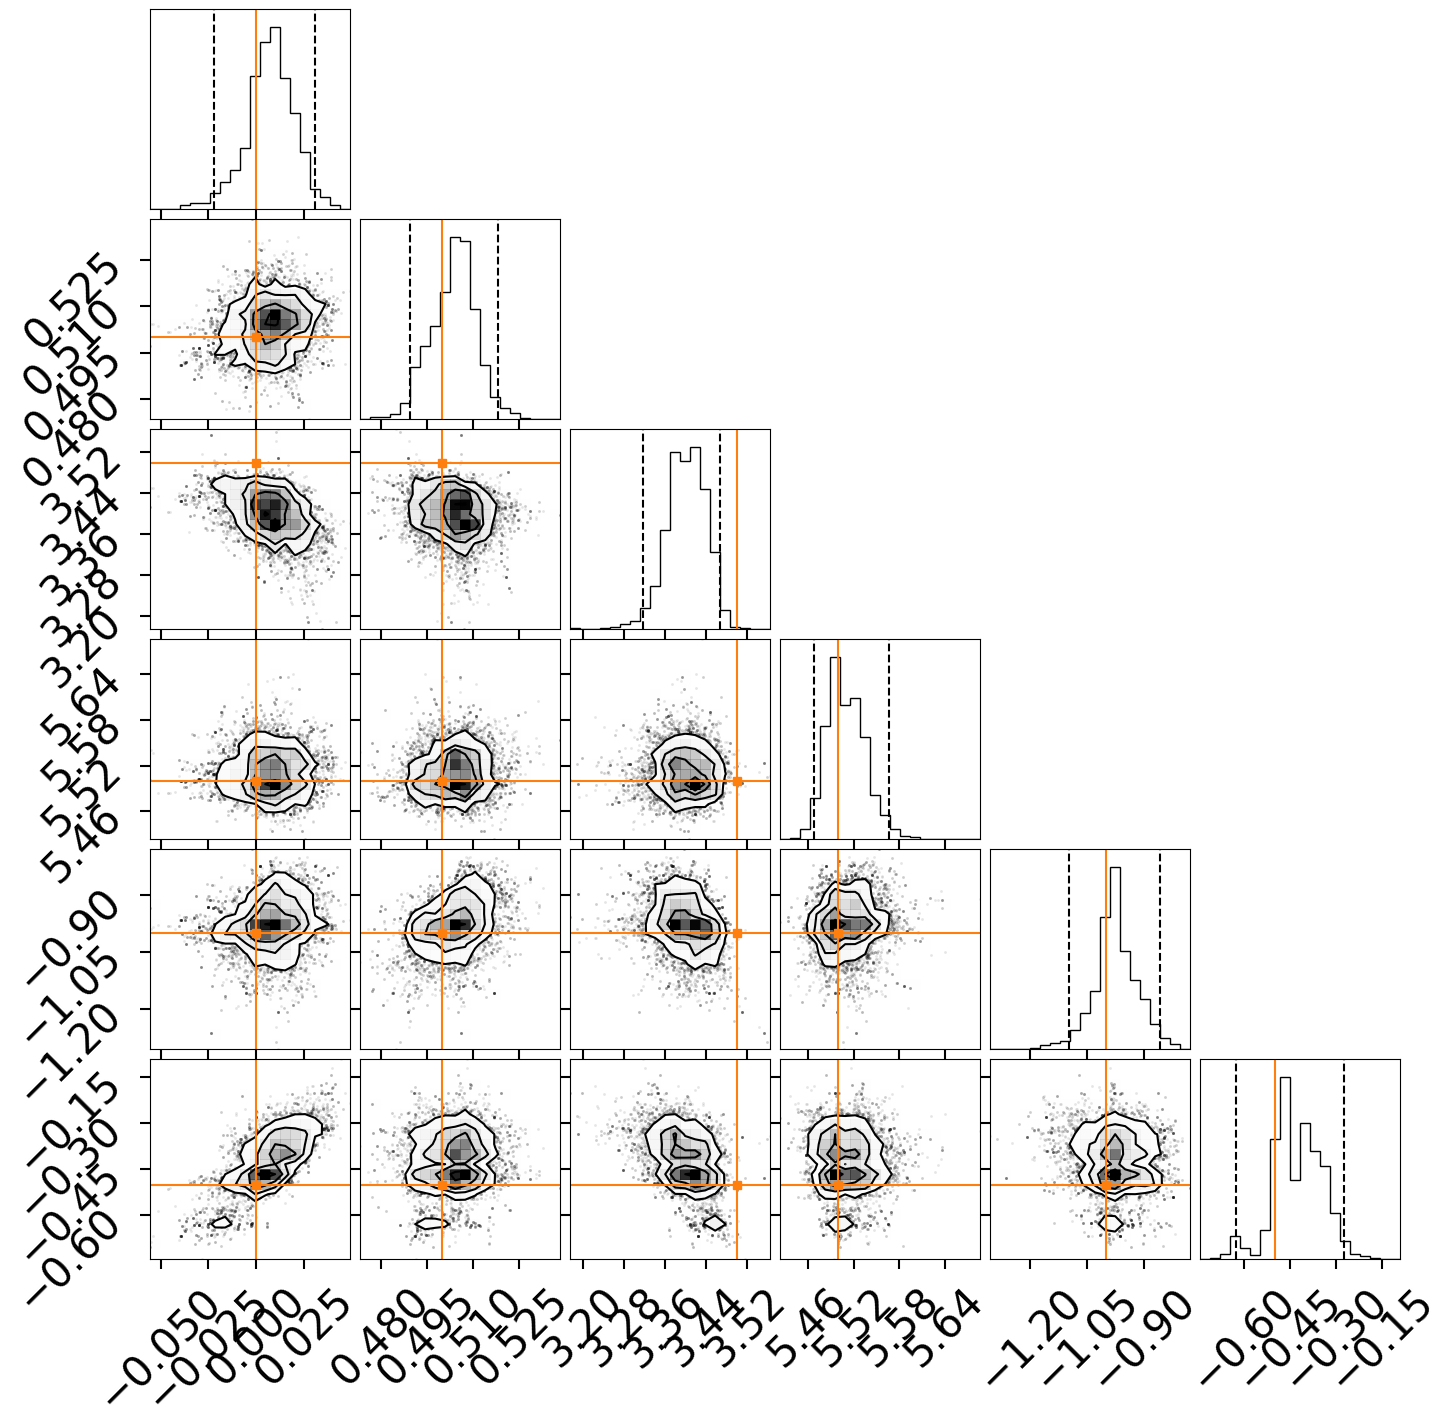

In [58]:
mcmc_sample_flat=sampler.get_chain(flat=True)
fig=corner.corner(mcmc_sample_flat,quantiles=[0.025,0.975])
truth=np.array([0,0.5,3.5,5.5,-1,-0.5])
corner.overplot_lines(fig, truth, color="C1")
corner.overplot_points(fig, truth[None], marker="s", color="C1")


In [64]:
mu=sum(mcmc_sample_flat)/mcmc_sample_flat.shape[0]
print(mu)
cov=np.cov(mcmc_sample_flat.T)
print(cov.shape)
print(cov)

[ 0.00727295  0.50371111  3.40082519  5.51035966 -0.97560213 -0.42536971]
(6, 6)
[[ 1.64883858e-04  1.71377198e-05 -2.16206390e-04  2.54142630e-06
   1.20368882e-04  7.46238881e-04]
 [ 1.71377198e-05  5.40788964e-05 -4.94253517e-05  1.70681585e-05
   1.60677743e-04  5.85178660e-05]
 [-2.16206390e-04 -4.94253517e-05  1.55679570e-03 -4.12871284e-05
  -7.08705204e-04 -1.42469317e-03]
 [ 2.54142630e-06  1.70681585e-05 -4.12871284e-05  6.55199531e-04
   1.63674634e-04 -1.09181242e-04]
 [ 1.20368882e-04  1.60677743e-04 -7.08705204e-04  1.63674634e-04
   3.40789096e-03 -4.23026374e-04]
 [ 7.46238881e-04  5.85178660e-05 -1.42469317e-03 -1.09181242e-04
  -4.23026374e-04  6.60317978e-03]]


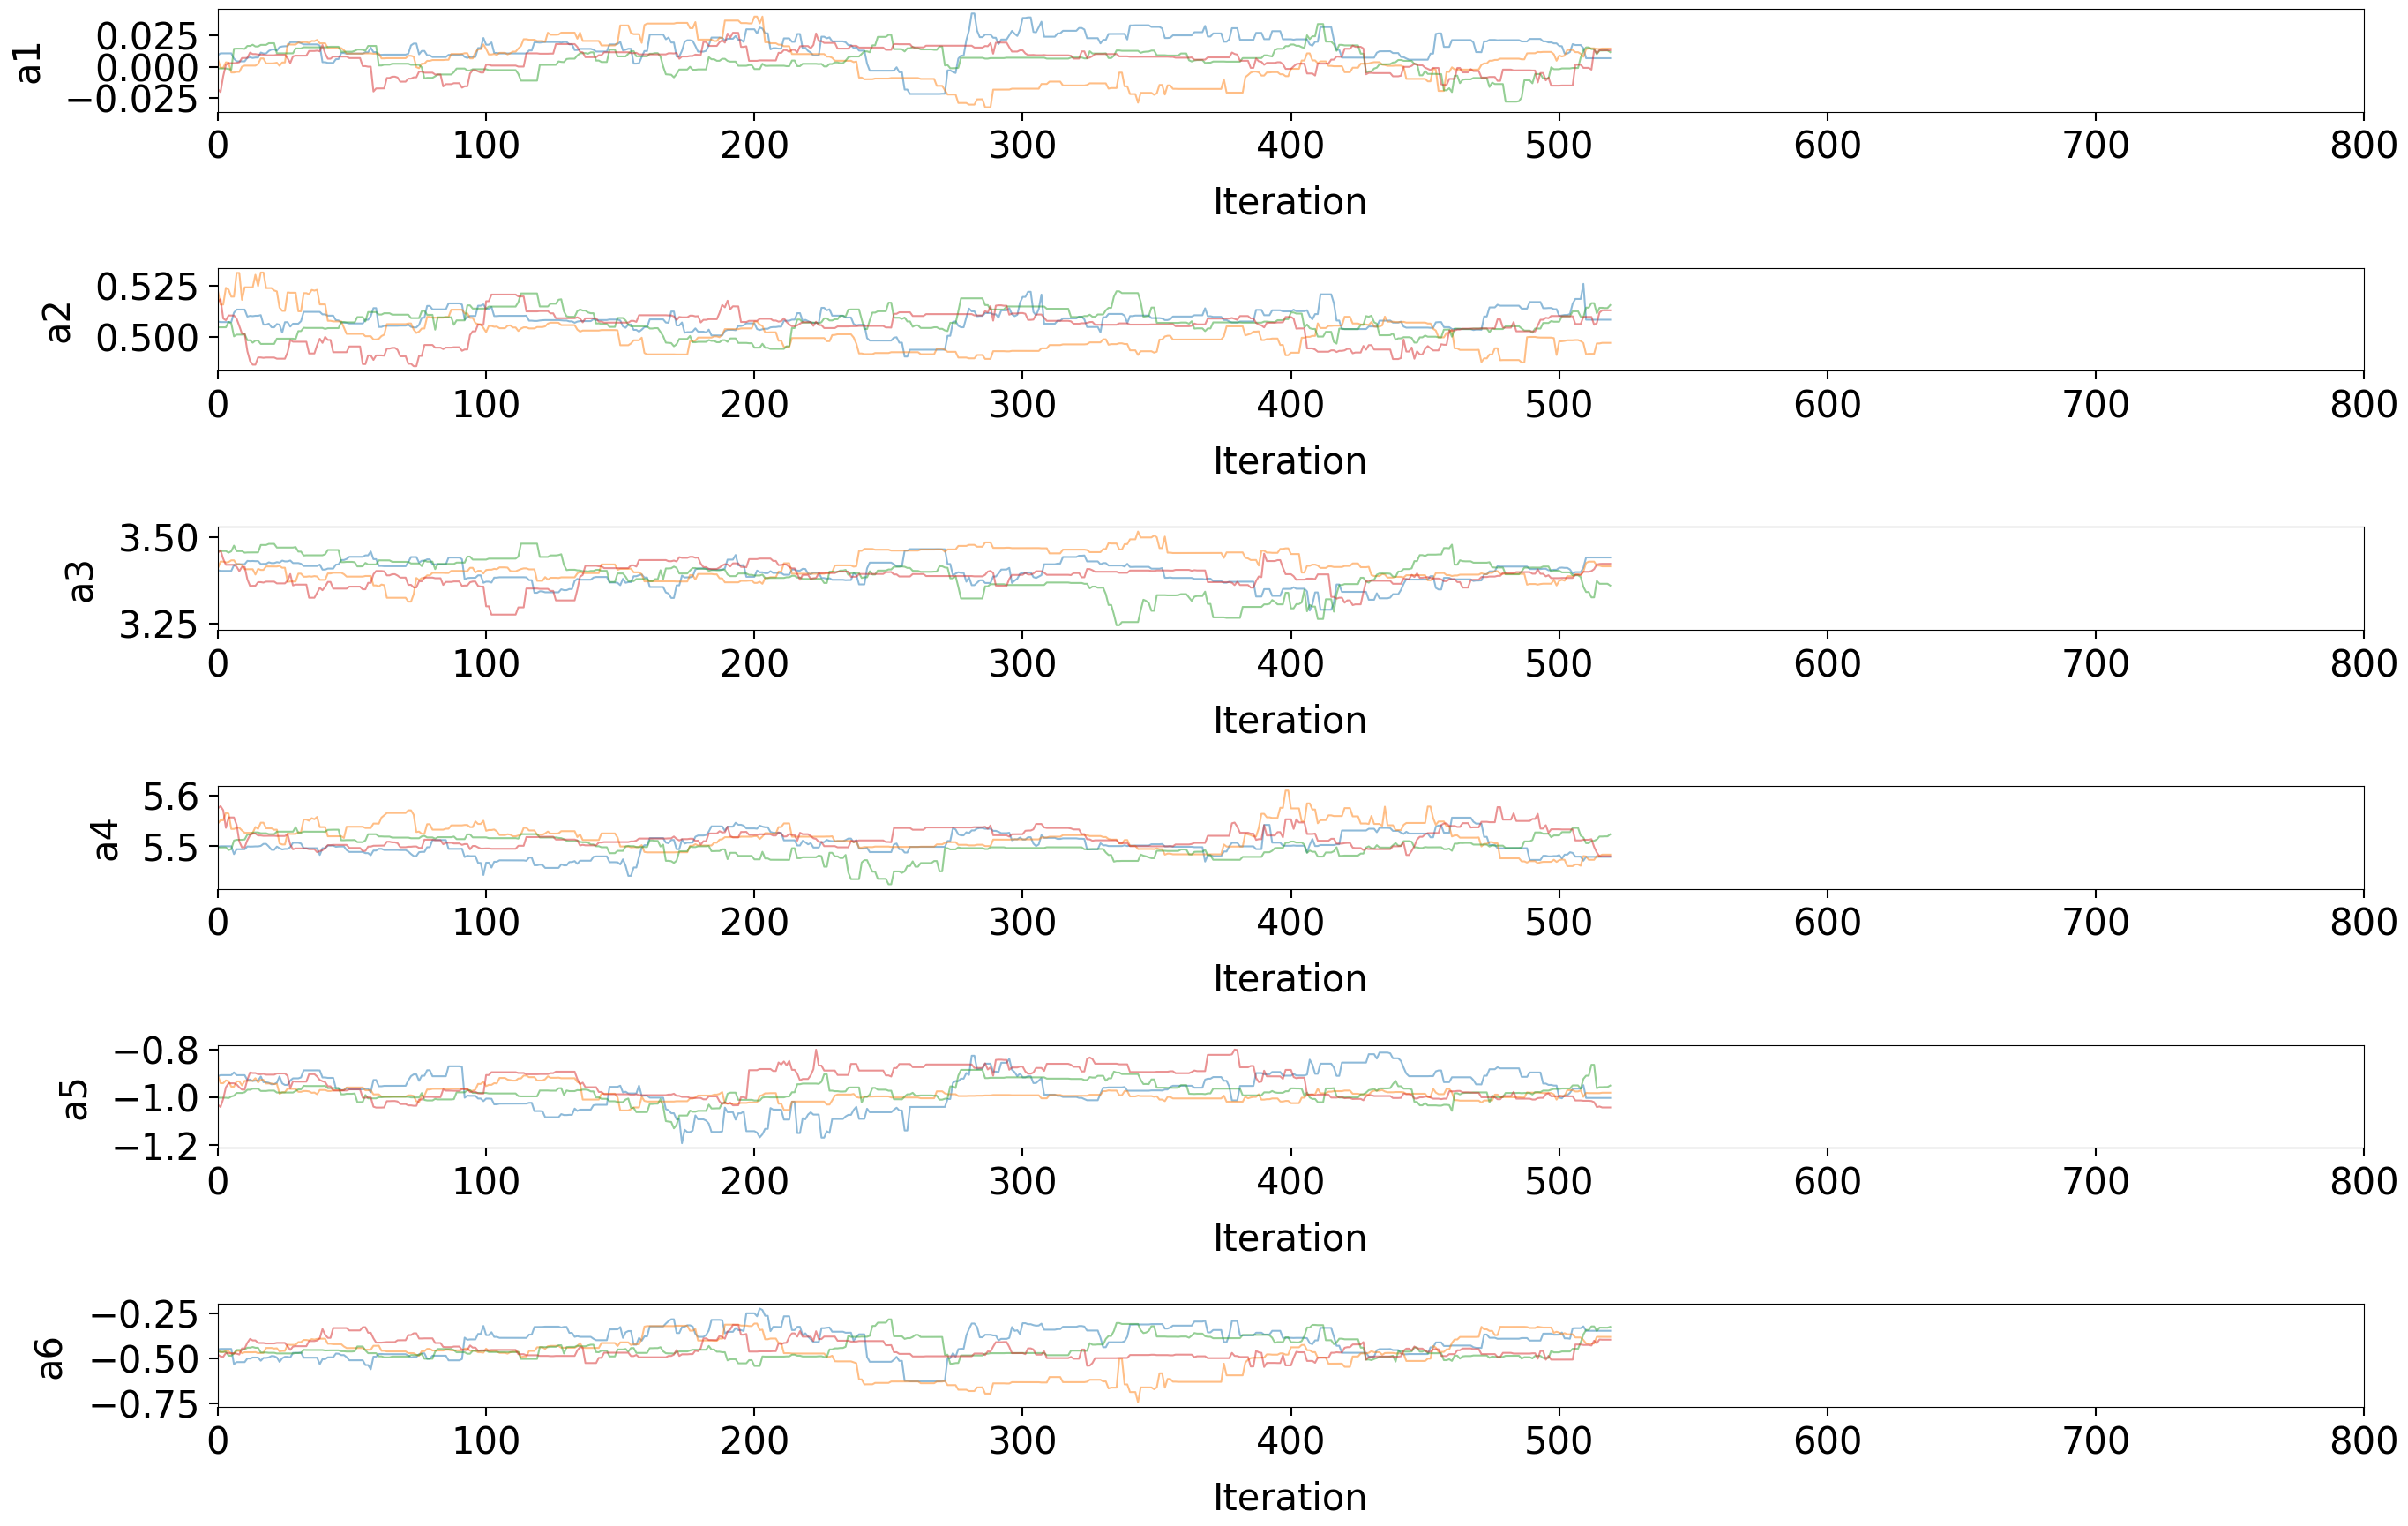

In [59]:
# plot a few chains
mcmc_sample=sampler.get_chain()
plt.figure(figsize=(28, 18))

plt.subplot(6, 1, 1)
[plt.plot(mcmc_sample[:, i, 0], alpha=0.5) for i in range(4)]
plt.xlim([0, 800])
plt.xlabel('Iteration')
plt.ylabel('a1')

plt.subplot(6, 1, 2)
[plt.plot(mcmc_sample[:, i, 1], alpha=0.5) for i in range(4)]
plt.xlabel('Iteration')
plt.ylabel('a2')
plt.xlim([0, 800])

plt.subplot(6, 1, 3)
[plt.plot(mcmc_sample[:, i, 2], alpha=0.5) for i in range(4)]
plt.xlim([0, 800])
plt.xlabel('Iteration')
plt.ylabel('a3')
plt.subplot(6, 1, 4)
[plt.plot(mcmc_sample[:, i, 3], alpha=0.5) for i in range(4)]
plt.xlim([0, 800])
plt.xlabel('Iteration')
plt.ylabel('a4')
plt.subplot(6, 1, 5)
[plt.plot(mcmc_sample[:, i, 4], alpha=0.5) for i in range(4)]
plt.xlim([0, 800])
plt.xlabel('Iteration')
plt.ylabel('a5')
plt.subplot(6, 1, 6)
[plt.plot(mcmc_sample[:, i, 5], alpha=0.5) for i in range(4)]
plt.xlim([0, 800])
plt.xlabel('Iteration')
plt.ylabel('a6')
plt.tight_layout()

In [60]:
def mvn_proposal_sampling(n):
    alpha_sample=np.random.multivariate_normal(mean=mu,cov=cov/4,size=n)
    return alpha_sample
#Proposal Distribution for importance sampling

In [ ]:
n=5000
alpha_sample=mvn_proposal_sampling(n)
log_weights=[]
for alpha in alpha_sample:
    diff=alpha-mu
    logw=sum(tmodel.log_P_alpha_given_M(alpha))
    logw-=0.5*diff.T@np.linalg.inv(cov/4)@diff
    #W_i=P_i/Q_i
    log_weights.append(logw)
log_weights-=(max(log_weights))*np.ones(n)
#Normalize to prevent underflow
weights=np.exp(log_weights)
n_eff=sum(weights)**2/sum(weights**2)
print(n_eff)

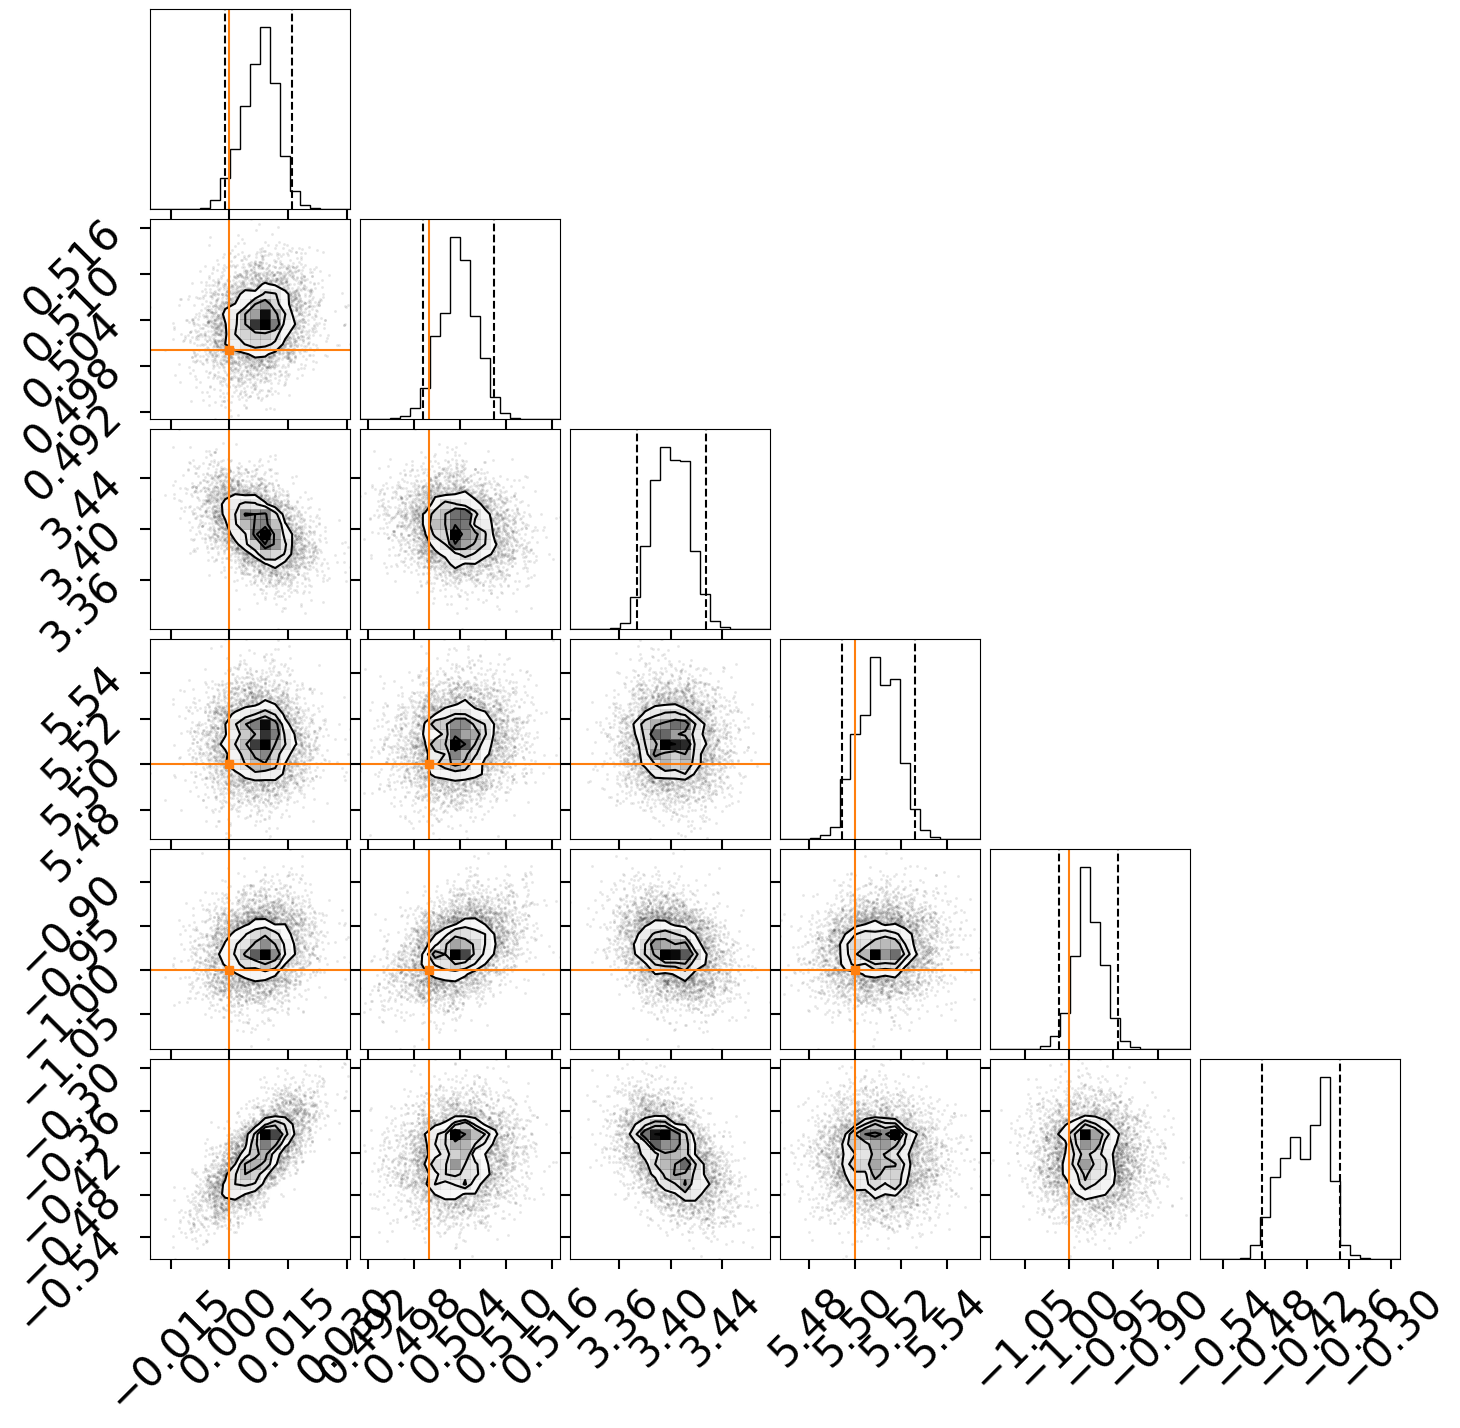

In [63]:
fig=corner.corner(alpha_sample,weights=weights,figsize=(30,30),quantiles=[0.025,0.975],range=[1,1,1,1,1,1])
truth=np.array([0,0.5,3.5,5.5,-1,0.5])
corner.overplot_lines(fig, truth, color="C1")
corner.overplot_points(fig, truth[None], marker="s", color="C1")

In [65]:
real_loga=[]
for t in test_theta:

    mags,params,params_sec=sedmaker.get_sed(mini=10**t[0], feh=t[2],eep=t[1]*100, smf=0,av=0., rv=3.3,dist=10.)
    loga=params['loga']
    real_loga.append(loga)
#Get the Star Formation HIstory, or age distribution of the test_x based on real theta

In [66]:
post_loga=[]
for x in test_x:
    t=posterior.sample((1,),x=x)
    t=np.asarray(t)
    t=t[0]
    mags,params,params_sec=sedmaker.get_sed(mini=10**t[0], feh=t[2],eep=t[1]*100, smf=0,av=0., rv=3.3,dist=10.)
    loga=params['loga']
    while (np.isnan(loga)):
        t=posterior.sample((1,),x=x)
        t=np.asarray(t)[0]
        mags,params,params_sec=sedmaker.get_sed(mini=10**t[0], feh=t[2],eep=t[1]*100, smf=0,av=0., rv=3.3,dist=10.)
        loga=params['loga']

    post_loga.append(loga)
#Get the Star Formation HIstory, or age distribution based on posterior distribution of theta given test_x

Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 144.16it/s]
Drawing 1 posterior samples: 9311it [00:04, 2088.86it/s]          
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 355.60it/s]
Drawing 1 posterior samples: 9203it [00:04, 2006.62it/s]          
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 235.29it/s]
Drawing 1 posterior samples: 9002it [00:04, 2123.21it/s]          
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 337.54it/s]
Drawing 1 posterior samples: 8269it [00:04, 1987.26it/s]          
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 339.15it/s]
Drawing 1 posterior samples: 8338it [00:04, 1958.86it/s]          
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 349.29it/s]
Drawing 1 posterior samples: 9093it [00:04, 2191.15it/s]          
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 345.49it/s]


In [70]:
idx2=np.random.randint(0,mcmc_sample_flat.shape[0]-1)
est=mcmc_sample_flat[idx2]
print(est)
#Generate a sample alpha from the Markov chain
estimated_prior=utils.BoxUniform(low=[est[0],est[2],est[4]],high=[est[1],est[3],est[5]])
est_theta, est_x = simulate_for_sbi(simulator, estimated_prior, num_simulations=200)
k = torch.any(torch.isnan(est_x), axis = 1)
est_theta=est_theta[~k]
est_x=est_x[~k]
est_loga=[]
for t in est_theta:
    mags,params,params_sec=sedmaker.get_sed(mini=10**t[0], feh=t[2],eep=t[1]*100, smf=0,av=0., rv=3.3,dist=10.)
    loga=params['loga']
    est_loga.append(loga)
#Get the Star Formation HIstory, or age distribution based on some estimated alpha with high P(alpha|M)

[-1.13853284e-03  5.06238344e-01  3.45146667e+00  5.50675685e+00
 -9.73389664e-01 -4.71878527e-01]


Running 200 simulations.: 100%|██████████| 200/200 [00:00<00:00, 1523.52it/s]


In [71]:
from scipy.stats import ks_2samp

Text(0.5, 1.0, 'SFH under alpha in MCMC samples')

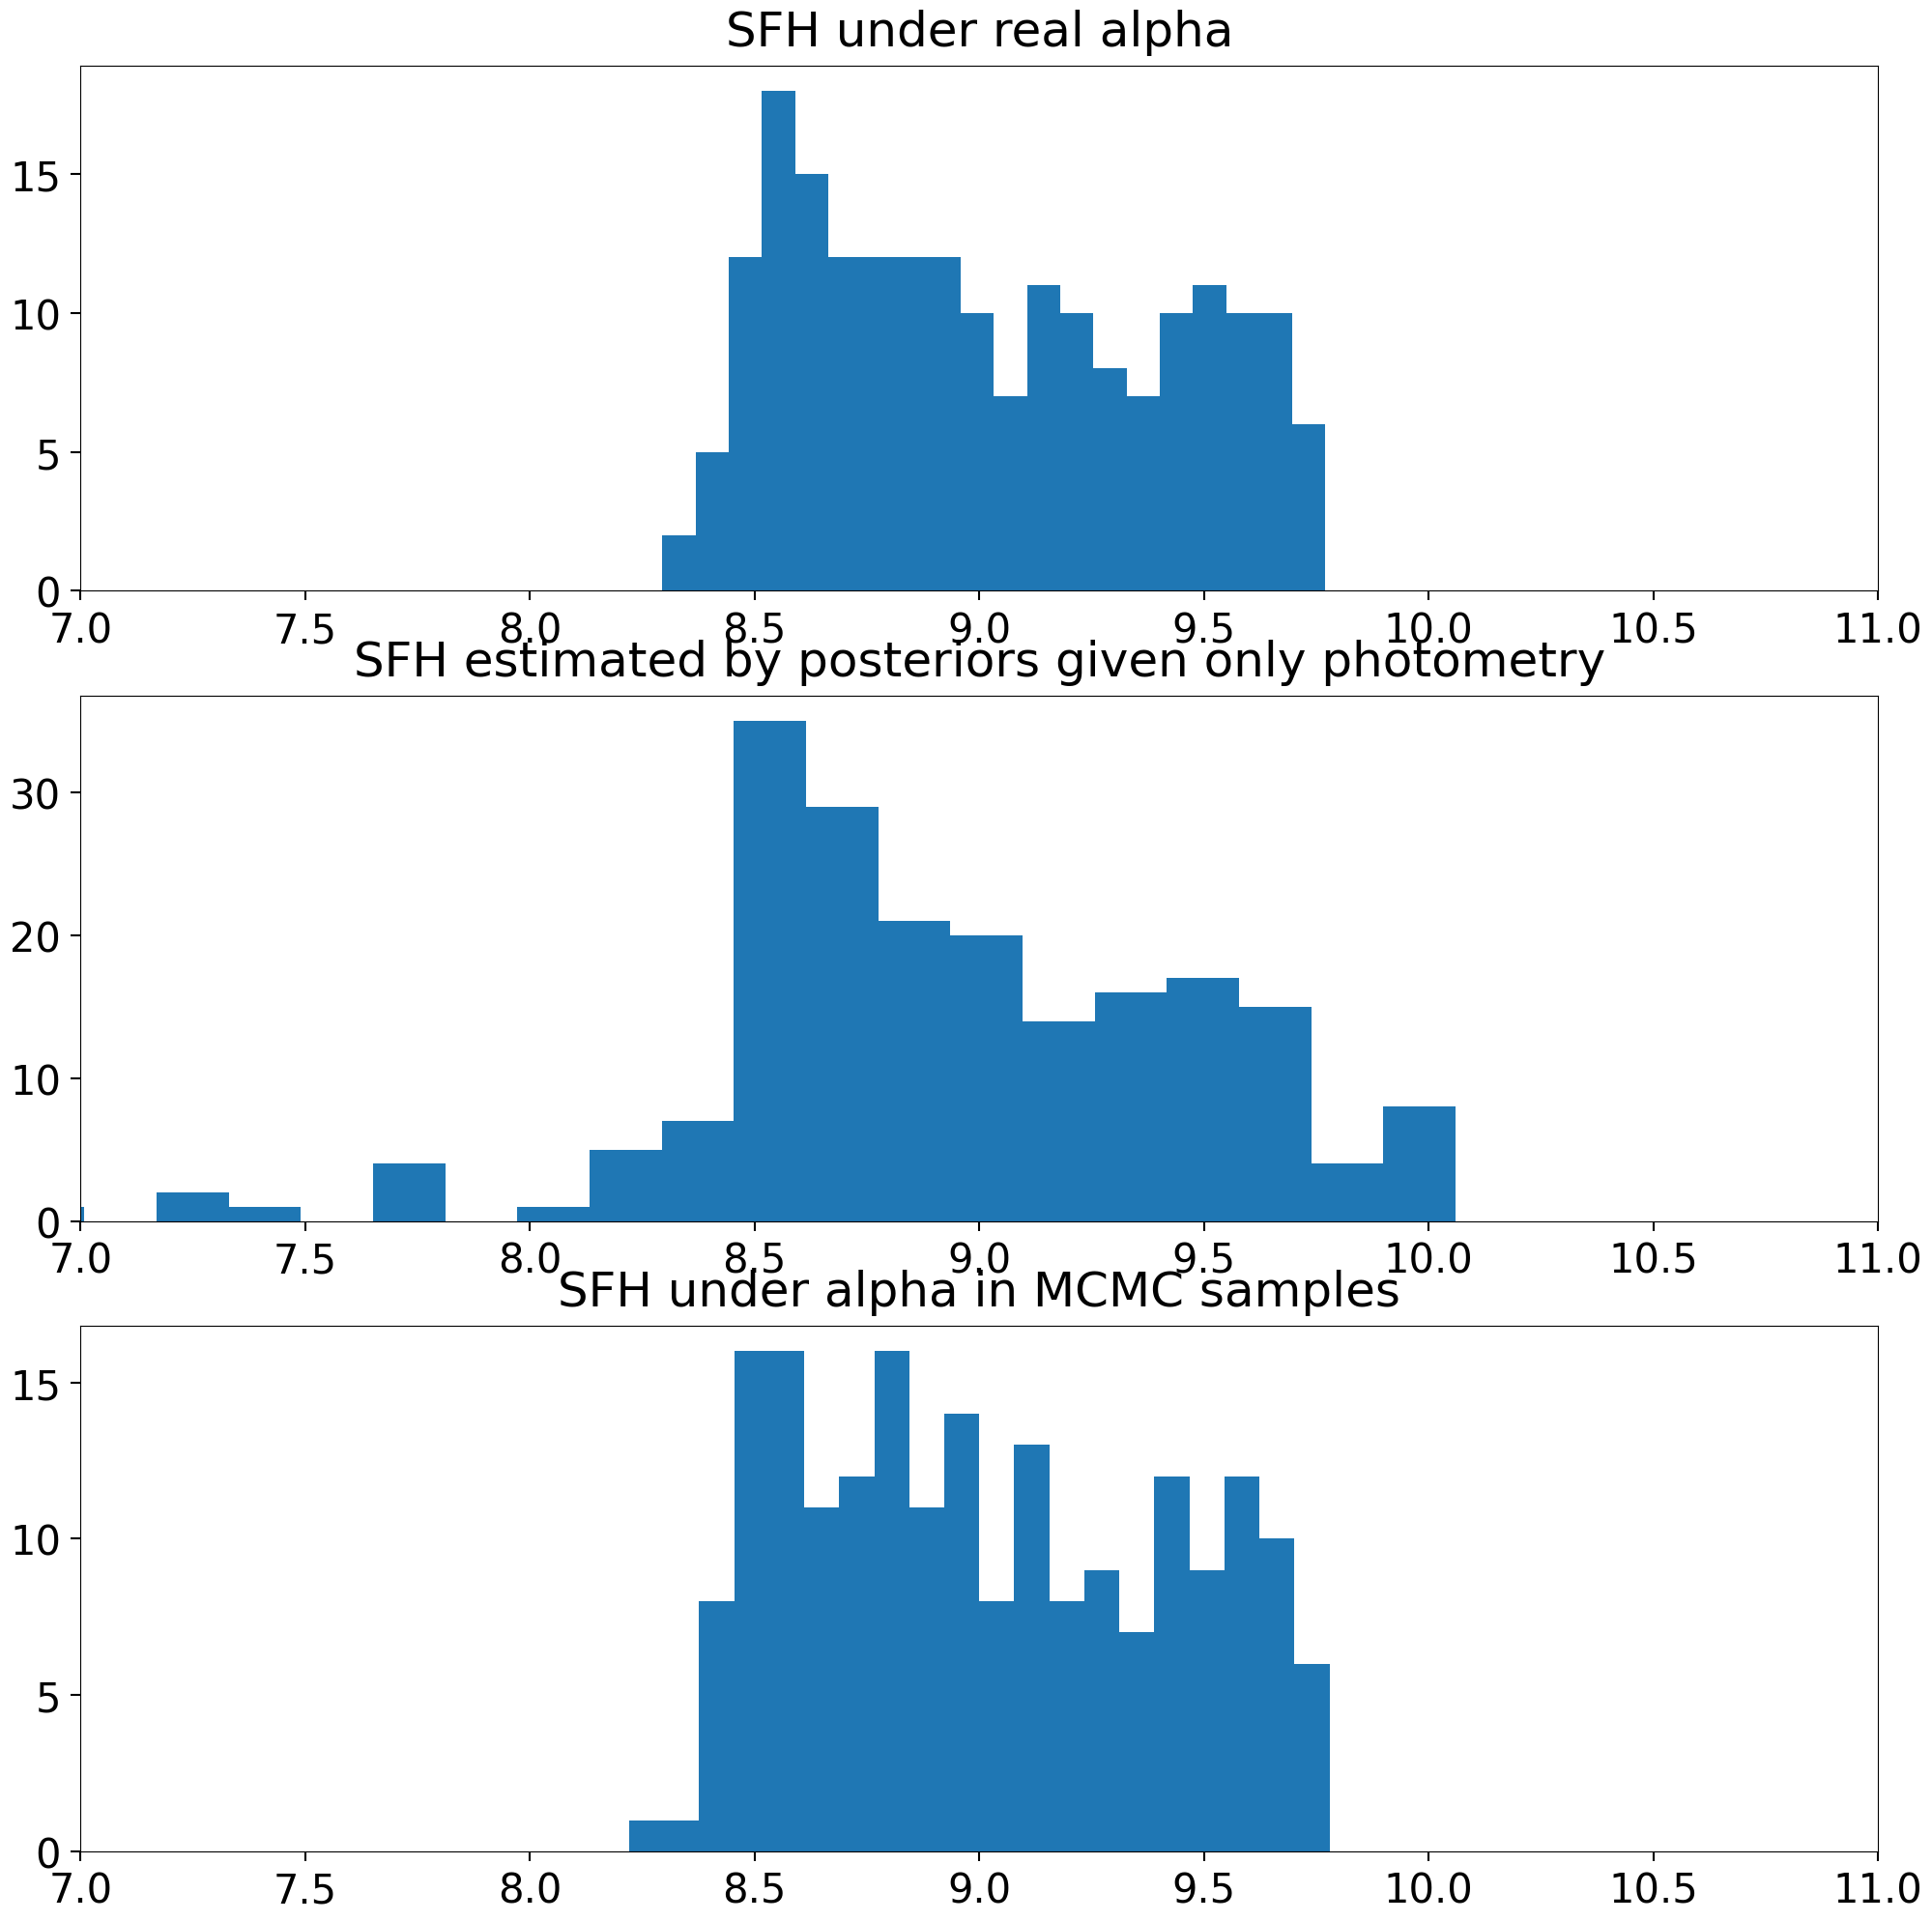

In [89]:
figs,axs=plt.subplots(3,figsize=(24,24))
axs[0].hist(real_loga,bins=20)
axs[0].set_xlim([7,11])
axs[0].set_title("SFH under real alpha")
axs[1].hist(post_loga,bins=20)
axs[1].set_xlim([7,11])
axs[1].set_title("SFH estimated by posteriors given only photometry")
axs[2].hist(est_loga,bins=20)
axs[2].set_xlim([7,11])
axs[2].set_title("SFH under alpha in MCMC samples")
#Plot the histograms

In [73]:
ks_2samp(real_loga,post_loga)

KstestResult(statistic=0.095, pvalue=0.32811544409418575, statistic_location=8.685847939515606, statistic_sign=-1)

In [74]:
ks_2samp(real_loga,est_loga)

KstestResult(statistic=0.04, pvalue=0.9973277498238406, statistic_location=8.580544675784793, statistic_sign=-1)

[-1.13853284e-03  5.06238344e-01  3.45146667e+00  5.50675685e+00
 -9.73389664e-01 -4.71878527e-01]


Running 200 simulations.: 100%|██████████| 200/200 [00:00<00:00, 2799.51it/s]


(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([0.49732775, 0.59732775, 0.69732775, 0.79732775, 0.89732775,
        0.99732775, 1.09732775, 1.19732775, 1.29732775, 1.39732775,
        1.49732775]),
 <BarContainer object of 10 artists>)

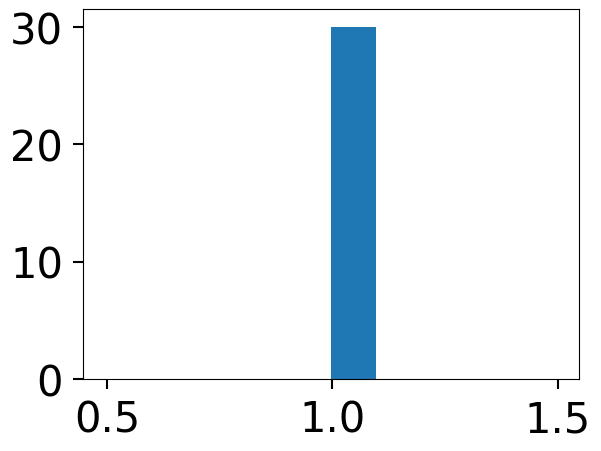

In [79]:
print(est)
p_list=[]
for i in range(30):
    est_theta, est_x = simulate_for_sbi(simulator, estimated_prior, num_simulations=200)
    k= torch.any(torch.isnan(est_x), axis = 1)
    est_theta=est_theta[~k]
    est_x=est_x[~k]
    est_loga=[]
    for t in est_theta:
        mags,params,params_sec=sedmaker.get_sed(mini=10**t[0], feh=t[2],eep=t[1]*100, smf=0,av=0., rv=3.3,dist=10.)
        loga=params['loga']
        est_loga.append(loga)
    pval=ks_2samp(real_loga,est_loga).pvalue
    p_list.append(pval)
plt.hist(p_list)